# Using CAM for Visualizing CNNs

### What is CAM?

CAM is short for Class Activation Maps. Lesson 7 of FastAI covers this. Have a look at https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-7-1b9503aff0c for a small overview of CAM. Here is the corresponding notebook https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-CAM.ipynb. Quite a few lines of code is derived from the later

### Why CAM?

CAM allows one to visualize which pixels of the original image are responsible for predicting the corresponding class. One can be more assured that the CNN is working properly and gain some intuitions where the CNNs are failing. Moreover, it localizes the main object in the image.

In this I will try to visualize both CAM (https://arxiv.org/pdf/1512.04150.pdf) as well as Grad-CAM (https://arxiv.org/pdf/1610.02391v1.pdf). Grad-CAM is considered to be more general than CAM (as reported here https://raghakot.github.io/keras-vis/visualizations/class_activation_maps/)

The respective codes can be found CAM(https://github.com/metalbubble/CAM) and GradCAM(https://github.com/jacobgil/pytorch-grad-cam). I will be heavily using the two in the two notebooks.

As usual, we will work with the dogscats dataset.

Also I would highly recommend having seen the Forward Hooks notebook https://github.com/TheShadow29/FAI-notes/blob/master/notebooks/Using-Forward-Hook-To-Save-Features.ipynb

In [1]:
import matplotlib
matplotlib.use('Agg')

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [138]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import skimage.transform as skt

In [4]:
PATH = "../data/dogscats/"
sz=224

In [111]:
arch=resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [6]:
class SaveFeatures:
    def __init__(self, m):
        self.handle = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, m, inp, outp):
        self.features = outp
    def remove(self):
        self.handle.remove()

In this case, we will not use the ConvLearner.pretrained as it introduces two linear layers. In this, we instead use only one linear layer. First, we will try without linear layers, instead using simply convolution layer and then using Adaptive Avg Pooling.

Following lesson7-CAM https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-CAM.ipynb

In [112]:
m1 = arch(True)
m = nn.Sequential(*children(m1)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [113]:
m[8]

Conv2d(512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

We need to get the output of the second convolution layer that we added. Before that we can go ahead and define our learner as well.

In [114]:
m = to_gpu(m)

In [115]:
learn = ConvLearner.from_model_data(m, data)

In [38]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 56

We need to freeze to the -4 because others before that are already trained

In [116]:
learn.freeze_to(-4)

In [117]:
learn.fit(1e-2, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.187423   0.176769   0.987     


[array([0.17677]), 0.987]

In [118]:
learn.fit(1e-2, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.15066    0.145268   0.99      


[array([0.14527]), 0.99]

At this point our model has learned and achieves 99% accuracy. We need to again call our model

In [119]:
m = learn.model

In [120]:
sf = [SaveFeatures(ml) for ml in [m[8]]]

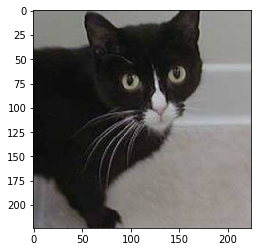

In [132]:
x, y = next(iter(data.val_dl))

idx = 1

x1 = data.val_ds.denorm(x)
plt.imshow(x1[idx])

In [133]:
log_prob = m(to_gpu(V(x)))

fts = sf[0].features[idx]

prob = np.exp(to_np(log_prob))

fts_np = to_np(fts)

In [134]:
f2=np.dot(np.rollaxis(fts_np,0,3), prob[idx])
f2-=f2.min()
f2/=f2.max()
f2

array([[0.06043, 0.14948, 0.22939, 0.27781, 0.30392, 0.27761, 0.16564],
       [0.14636, 0.33999, 0.51733, 0.61601, 0.63735, 0.55012, 0.32799],
       [0.23447, 0.52887, 0.79449, 0.91815, 0.8949 , 0.71883, 0.41187],
       [0.26572, 0.59751, 0.8896 , 1.     , 0.91418, 0.67211, 0.35607],
       [0.24012, 0.52854, 0.76507, 0.82435, 0.7063 , 0.4734 , 0.23057],
       [0.14279, 0.32476, 0.4651 , 0.48254, 0.38133, 0.22273, 0.0849 ],
       [0.03641, 0.11681, 0.18117, 0.18205, 0.12922, 0.05444, 0.     ]], dtype=float32)

/scratch/arka/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


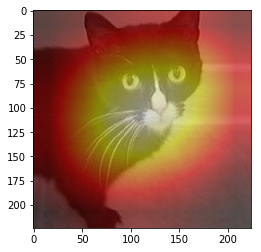

In [140]:
plt.imshow(x1[idx])
plt.imshow(scipy.misc.imresize(f2, x1[idx].shape), alpha=0.5, cmap='hot');

This shows that the model correctly sees the cat.

Now we will try to do the same with one linear layer instead at the end. Note the changes: We have converted the convolution to 

In [142]:
m1 = arch(True)
mlin = nn.Sequential(*children(m1)[:-2], 
                  nn.Conv2d(512, 256, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(),
                  nn.Linear(256, 2),
                  nn.LogSoftmax())

In [143]:
learn_lin = ConvLearner.from_model_data(to_gpu(mlin), data)

In [145]:
learn_lin.freeze_to(-5)

In [146]:
learn_lin.fit(1e-2, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.029823   0.029757   0.9895    


[array([0.02976]), 0.9895]

In [ ]:
learn_lin.fit(1e-2, 1, cycle_len=1)

 49%|████▉     | 176/360 [00:25<00:26,  6.91it/s, loss=0.0331]